# Sweep: Baseline vs ResNet at 16x Compression

Fair architecture comparison with correct hyperparameters.

**Previous failures:** LR too high (7e-3), base_channels too small (32), OneCycleLR overshoot.  
**This sweep:** LR=1e-4, AdamW, ReduceLROnPlateau, base_channels=64.

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=runs
```

## 1. Setup

In [1]:
import sys
import gc
import time
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
from tqdm.auto import tqdm

from src.data.datamodule import SARDataModule
from src.models.autoencoder import SARAutoencoder
from src.models.resnet_autoencoder import ResNetAutoencoder
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"Project root: {project_root}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Project root: d:\Projects\CNNAutoencoderProject
PyTorch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Sweep Configuration

In [2]:
# ============================================================
# SWEEP CONFIGURATION
# ============================================================

# Data
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 16
NUM_WORKERS = 4
VAL_FRACTION = 0.1
TRAIN_SUBSET = 0.10

# Fixed training params (proven with baseline@16x -> 20.47 dB)
LATENT_CHANNELS = 16  # 16x compression for all
EPOCHS = 35
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 12
LR_PATIENCE = 10
LR_FACTOR = 0.5
MSE_WEIGHT = 0.5
SSIM_WEIGHT = 0.5

# Sweep variable: model architecture
SWEEP_CONFIGS = [
    {'name': 'baseline',  'cls': SARAutoencoder,       'base_channels': 64, 'extra_kwargs': {}},
    {'name': 'resnet',    'cls': ResNetAutoencoder,     'base_channels': 64, 'extra_kwargs': {'in_channels': 1}},
]

# ============================================================

compression_ratio = (256 * 256) / (16 * 16 * LATENT_CHANNELS)
print(f"Compression: {compression_ratio:.0f}x (LC={LATENT_CHANNELS})")
print(f"LR={LEARNING_RATE}, Epochs={EPOCHS}, Patience={EARLY_STOPPING_PATIENCE}")
print(f"Data: {TRAIN_SUBSET*100:.0f}% subset, batch_size={BATCH_SIZE}")
print()
print("Sweep Plan:")
for cfg in SWEEP_CONFIGS:
    name = f"{cfg['name']}_c{LATENT_CHANNELS}_b{cfg['base_channels']}_cr{int(compression_ratio)}x"
    print(f"  {name}")
print(f"\nTotal runs: {len(SWEEP_CONFIGS)}")

Compression: 16x (LC=16)
LR=0.0001, Epochs=35, Patience=12
Data: 10% subset, batch_size=16

Sweep Plan:
  baseline_c16_b64_cr16x
  resnet_c16_b64_cr16x

Total runs: 2


## 3. Load Data

In [3]:
import random

print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

if TRAIN_SUBSET < 1.0:
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)

    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)

    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

print(f"\nPreprocessing params: {dm.preprocessing_params}")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 10% subset:
  Train: 62,665 of 626,650
  Val: 6,962 of 69,627

Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}


## 4. Run Sweep

In [4]:
import glob

results = []

sweep_pbar = tqdm(SWEEP_CONFIGS, desc="Sweep Progress", unit="run")

for cfg in sweep_pbar:
    model_name = cfg['name']
    base_channels = cfg['base_channels']
    run_name = f"{model_name}_c{LATENT_CHANNELS}_b{base_channels}_cr{int(compression_ratio)}x"
    sweep_pbar.set_postfix_str(run_name)

    # Check for existing checkpoint — skip if already trained
    existing = glob.glob(f'checkpoints/{run_name}_*/best.pth')
    if existing:
        checkpoint_path = existing[-1]  # most recent
        print(f"\n{'=' * 70}")
        print(f"  SKIPPING {run_name} — checkpoint exists")
        print(f"  {checkpoint_path}")
        print(f"{'=' * 70}")

        # Load checkpoint to extract metrics
        ckpt = torch.load(checkpoint_path, weights_only=False)
        log_dir = checkpoint_path.replace('checkpoints', 'runs').replace('/best.pth', '').replace('\\best.pth', '')

        # Run quick validation to get metrics
        model = cfg['cls'](
            latent_channels=LATENT_CHANNELS,
            base_channels=base_channels,
            **cfg['extra_kwargs'],
        )
        model.load_state_dict(ckpt['model_state_dict'])
        model.eval().cuda()
        params = model.count_parameters()

        loss_fn_tmp = CombinedLoss(mse_weight=MSE_WEIGHT, ssim_weight=SSIM_WEIGHT)
        val_loader = dm.val_dataloader()

        val_losses, val_psnrs, val_ssims = [], [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.cuda()
                output, _ = model(batch)
                loss, metrics = loss_fn_tmp(output, batch)
                val_losses.append(loss.item())
                val_psnrs.append(metrics['psnr'])
                val_ssims.append(metrics['ssim'])

        best_psnr = sum(val_psnrs) / len(val_psnrs)
        best_ssim = sum(val_ssims) / len(val_ssims)
        best_loss = sum(val_losses) / len(val_losses)

        result = {
            'run_name': Path(checkpoint_path).parent.name,
            'model': model_name,
            'base_channels': base_channels,
            'parameters': params['total'],
            'epochs_trained': ckpt.get('epoch', '?'),
            'elapsed_min': 0,
            'checkpoint': checkpoint_path,
            'log_dir': log_dir,
            'best_val_loss': best_loss,
            'best_psnr': best_psnr,
            'best_ssim': best_ssim,
            'skipped': True,
        }
        results.append(result)
        print(f"  Validated: PSNR={best_psnr:.2f} dB, SSIM={best_ssim:.4f}")

        del model, loss_fn_tmp, val_loader
        gc.collect()
        torch.cuda.empty_cache()
        continue

    print(f"\n{'=' * 70}")
    print(f"  {run_name}")
    print(f"{'=' * 70}")

    # Create model
    model = cfg['cls'](
        latent_channels=LATENT_CHANNELS,
        base_channels=base_channels,
        **cfg['extra_kwargs'],
    )
    params = model.count_parameters()
    print(f"  Parameters: {params['total']:,}")

    # Loss
    loss_fn = CombinedLoss(mse_weight=MSE_WEIGHT, ssim_weight=SSIM_WEIGHT)

    # Trainer config
    config = {
        'learning_rate': LEARNING_RATE,
        'optimizer': 'adamw',
        'scheduler': 'plateau',
        'lr_patience': LR_PATIENCE,
        'lr_factor': LR_FACTOR,
        'max_grad_norm': 1.0,
        'use_amp': True,
        'notebook': True,
        'run_name': run_name,
        'preprocessing_params': dm.preprocessing_params,
        'model_type': model_name,
        'latent_channels': LATENT_CHANNELS,
        'base_channels': base_channels,
        'mse_weight': MSE_WEIGHT,
        'ssim_weight': SSIM_WEIGHT,
        'batch_size': BATCH_SIZE,
        'compression_ratio': compression_ratio,
    }

    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        config=config,
    )

    # Train
    t0 = time.time()
    history = trainer.train(
        epochs=EPOCHS,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
    )
    elapsed = time.time() - t0

    # Collect results
    result = {
        'run_name': trainer.run_name,
        'model': model_name,
        'base_channels': base_channels,
        'parameters': params['total'],
        'epochs_trained': len(history),
        'elapsed_min': elapsed / 60,
        'checkpoint': str(trainer.checkpoint_dir / 'best.pth'),
        'log_dir': str(trainer.log_dir),
        'skipped': False,
    }

    if history:
        best_epoch = min(history, key=lambda h: h.get('val_loss', float('inf')))
        result['best_val_loss'] = best_epoch.get('val_loss')
        result['best_psnr'] = best_epoch.get('val_psnr')
        result['best_ssim'] = best_epoch.get('val_ssim')

    results.append(result)

    psnr_str = f"{result.get('best_psnr', 0):.2f} dB" if result.get('best_psnr') else "N/A"
    print(f"\n  Done: {psnr_str} | {elapsed/60:.1f} min | {trainer.checkpoint_dir / 'best.pth'}")

    # Cleanup GPU
    del model, trainer, loss_fn, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

print("\nSweep complete!")

Sweep Progress:   0%|          | 0/2 [00:00<?, ?run/s]


  SKIPPING baseline_c16_b64_cr16x — checkpoint exists
  checkpoints\baseline_c16_b64_cr16x_20260127_231730\best.pth
  Validated: PSNR=19.09 dB, SSIM=0.5721

  resnet_c16_b64_cr16x
  Parameters: 22,395,873
Using device: cuda


d:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-28 00:39:26,730 - Log directory: runs\resnet_c16_b64_cr16x_20260128_003926
2026-01-28 00:39:26,730 - Checkpoint directory: checkpoints\resnet_c16_b64_cr16x_20260128_003926
2026-01-28 00:39:26,730 - Mixed Precision (AMP): enabled
2026-01-28 00:39:26,732 - Starting training for 35 epochs
2026-01-28 00:39:26,733 - Model: ResNetAutoencoder
2026-01-28 00:39:26,733 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'resnet_c16_b64_cr16x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'resnet', 'latent_channels': 16, 'base_channels': 64, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size': 

GPU memory: 634MB / 8192MB (8% used, 7.4 GB free)
Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 01:40:15,866 - Skipped 1 batches with NaN values
2026-01-28 01:40:18,987 - New best model saved (val_loss: 0.2223) + archived to best_20260128_014018_epoch000_loss0.2223.pth
2026-01-28 01:40:19,657 - Epoch 1/35 | Train: loss=0.2762, psnr=17.64, ssim=0.4655 | Val: loss=0.2223, psnr=16.07, ssim=0.5803 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 2 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 03:02:29,401 - Skipped 7 batches with NaN values
2026-01-28 03:02:30,368 - New best model saved (val_loss: 0.1712) + archived to best_20260128_030230_epoch001_loss0.1712.pth
2026-01-28 03:02:31,221 - Epoch 2/35 | Train: loss=0.1932, psnr=18.78, ssim=0.6270 | Val: loss=0.1712, psnr=19.94, ssim=0.6678 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 3 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 03:28:21,019 - Skipped 5 batches with NaN values
2026-01-28 03:28:22,103 - New best model saved (val_loss: 0.1645) + archived to best_20260128_032821_epoch002_loss0.1645.pth
2026-01-28 03:28:23,082 - Epoch 3/35 | Train: loss=0.1756, psnr=19.23, ssim=0.6610 | Val: loss=0.1645, psnr=19.76, ssim=0.6815 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 4 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 03:55:10,652 - Skipped 12 batches with NaN values
2026-01-28 03:55:11,758 - New best model saved (val_loss: 0.1572) + archived to best_20260128_035511_epoch003_loss0.1572.pth
2026-01-28 03:55:12,832 - Epoch 4/35 | Train: loss=0.1682, psnr=19.55, ssim=0.6747 | Val: loss=0.1572, psnr=20.47, ssim=0.6946 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 5 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 04:22:25,604 - Skipped 13 batches with NaN values
2026-01-28 04:22:26,686 - New best model saved (val_loss: 0.1550) + archived to best_20260128_042226_epoch004_loss0.1550.pth
2026-01-28 04:22:27,462 - Epoch 5/35 | Train: loss=0.1638, psnr=19.73, ssim=0.6831 | Val: loss=0.1550, psnr=20.78, ssim=0.6984 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 6 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 04:47:57,074 - Skipped 13 batches with NaN values
2026-01-28 04:47:58,229 - New best model saved (val_loss: 0.1543) + archived to best_20260128_044757_epoch005_loss0.1543.pth
2026-01-28 04:47:58,384 - Epoch 6/35 | Train: loss=0.1603, psnr=19.91, ssim=0.6896 | Val: loss=0.1543, psnr=20.28, ssim=0.7008 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 7 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 05:13:21,473 - Skipped 21 batches with NaN values
2026-01-28 05:13:22,314 - New best model saved (val_loss: 0.1515) + archived to best_20260128_051322_epoch006_loss0.1515.pth
2026-01-28 05:13:22,500 - Epoch 7/35 | Train: loss=0.1574, psnr=20.04, ssim=0.6952 | Val: loss=0.1515, psnr=20.92, ssim=0.7051 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 8 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 05:40:23,163 - Skipped 14 batches with NaN values
2026-01-28 05:40:24,285 - New best model saved (val_loss: 0.1477) + archived to best_20260128_054023_epoch007_loss0.1477.pth
2026-01-28 05:40:24,405 - Epoch 8/35 | Train: loss=0.1557, psnr=20.12, ssim=0.6984 | Val: loss=0.1477, psnr=20.86, ssim=0.7127 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 9 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 06:07:28,062 - Skipped 30 batches with NaN values
2026-01-28 06:07:28,471 - Epoch 9/35 | Train: loss=0.1539, psnr=20.23, ssim=0.7018 | Val: loss=0.1484, psnr=20.59, ssim=0.7119 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 10 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 06:33:00,631 - Skipped 8 batches with NaN values
2026-01-28 06:33:01,367 - New best model saved (val_loss: 0.1456) + archived to best_20260128_063301_epoch009_loss0.1456.pth
2026-01-28 06:33:01,477 - Epoch 10/35 | Train: loss=0.1516, psnr=20.32, ssim=0.7061 | Val: loss=0.1456, psnr=21.15, ssim=0.7165 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 11 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 06:58:04,381 - Skipped 5 batches with NaN values
2026-01-28 06:58:06,063 - Epoch 11/35 | Train: loss=0.1516, psnr=20.34, ssim=0.7060 | Val: loss=0.1522, psnr=20.52, ssim=0.7045 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 12 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 07:23:06,101 - Skipped 16 batches with NaN values
2026-01-28 07:23:06,464 - Epoch 12/35 | Train: loss=0.1499, psnr=20.41, ssim=0.7094 | Val: loss=0.1457, psnr=20.84, ssim=0.7168 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 13 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 07:48:01,757 - Skipped 38 batches with NaN values
2026-01-28 07:48:02,138 - Epoch 13/35 | Train: loss=0.1487, psnr=20.46, ssim=0.7117 | Val: loss=0.1463, psnr=19.52, ssim=0.7186 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 14 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 08:12:43,287 - Skipped 15 batches with NaN values
2026-01-28 08:12:44,118 - New best model saved (val_loss: 0.1449) + archived to best_20260128_081243_epoch013_loss0.1449.pth
2026-01-28 08:12:44,226 - Epoch 14/35 | Train: loss=0.1475, psnr=20.52, ssim=0.7139 | Val: loss=0.1449, psnr=20.60, ssim=0.7190 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 15 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 08:36:31,355 - Skipped 9 batches with NaN values
2026-01-28 08:36:31,763 - Epoch 15/35 | Train: loss=0.1461, psnr=20.52, ssim=0.7167 | Val: loss=0.1471, psnr=21.02, ssim=0.7138 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 16 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 09:00:15,801 - Skipped 16 batches with NaN values
2026-01-28 09:00:16,891 - New best model saved (val_loss: 0.1409) + archived to best_20260128_090016_epoch015_loss0.1409.pth
2026-01-28 09:00:16,995 - Epoch 16/35 | Train: loss=0.1457, psnr=20.58, ssim=0.7175 | Val: loss=0.1409, psnr=21.15, ssim=0.7258 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 17 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 09:24:11,761 - Skipped 10 batches with NaN values
2026-01-28 09:24:12,171 - Epoch 17/35 | Train: loss=0.1455, psnr=20.55, ssim=0.7178 | Val: loss=0.1460, psnr=20.13, ssim=0.7177 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 18 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 09:47:59,699 - Skipped 9 batches with NaN values
2026-01-28 09:48:00,064 - Epoch 18/35 | Train: loss=0.1444, psnr=20.56, ssim=0.7200 | Val: loss=0.1425, psnr=20.41, ssim=0.7242 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 19 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 10:11:48,078 - Skipped 13 batches with NaN values
2026-01-28 10:11:48,480 - Epoch 19/35 | Train: loss=0.1442, psnr=20.63, ssim=0.7203 | Val: loss=0.1465, psnr=20.40, ssim=0.7161 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 20 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 10:35:35,627 - Skipped 20 batches with NaN values
2026-01-28 10:35:36,031 - Epoch 20/35 | Train: loss=0.1434, psnr=20.58, ssim=0.7220 | Val: loss=0.1410, psnr=20.94, ssim=0.7261 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 21 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 10:59:20,502 - Skipped 17 batches with NaN values
2026-01-28 10:59:22,162 - Epoch 21/35 | Train: loss=0.1434, psnr=20.62, ssim=0.7219 | Val: loss=0.1413, psnr=21.19, ssim=0.7249 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 22 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 11:23:09,823 - Skipped 4 batches with NaN values
2026-01-28 11:23:10,250 - Epoch 22/35 | Train: loss=0.1430, psnr=20.67, ssim=0.7225 | Val: loss=0.1426, psnr=20.85, ssim=0.7231 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 23 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 11:46:53,433 - Skipped 5 batches with NaN values
2026-01-28 11:46:54,262 - New best model saved (val_loss: 0.1380) + archived to best_20260128_114654_epoch022_loss0.1380.pth
2026-01-28 11:46:54,365 - Epoch 23/35 | Train: loss=0.1432, psnr=20.68, ssim=0.7222 | Val: loss=0.1380, psnr=21.29, ssim=0.7315 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 24 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 12:10:42,011 - Skipped 20 batches with NaN values
2026-01-28 12:10:42,412 - Epoch 24/35 | Train: loss=0.1428, psnr=20.75, ssim=0.7228 | Val: loss=0.1501, psnr=19.08, ssim=0.7121 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 25 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 12:34:29,068 - Skipped 10 batches with NaN values
2026-01-28 12:34:29,490 - Epoch 25/35 | Train: loss=0.1421, psnr=20.75, ssim=0.7243 | Val: loss=0.1438, psnr=21.47, ssim=0.7195 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 26 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 12:58:15,385 - Skipped 33 batches with NaN values
2026-01-28 12:58:16,015 - Epoch 26/35 | Train: loss=0.1410, psnr=20.80, ssim=0.7263 | Val: loss=0.1393, psnr=21.11, ssim=0.7291 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 27 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 13:22:02,507 - Skipped 9 batches with NaN values
2026-01-28 13:22:03,367 - New best model saved (val_loss: 0.1375) + archived to best_20260128_132203_epoch026_loss0.1375.pth
2026-01-28 13:22:03,476 - Epoch 27/35 | Train: loss=0.1405, psnr=20.82, ssim=0.7272 | Val: loss=0.1375, psnr=21.49, ssim=0.7321 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 28 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 13:45:51,147 - Skipped 9 batches with NaN values
2026-01-28 13:45:51,539 - Epoch 28/35 | Train: loss=0.1403, psnr=20.80, ssim=0.7277 | Val: loss=0.1397, psnr=21.08, ssim=0.7284 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 29 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 14:10:14,656 - Skipped 5 batches with NaN values
2026-01-28 14:10:15,042 - Epoch 29/35 | Train: loss=0.1413, psnr=20.83, ssim=0.7256 | Val: loss=0.1453, psnr=19.74, ssim=0.7200 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 30 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 14:35:12,088 - Skipped 10 batches with NaN values
2026-01-28 14:35:12,484 - Epoch 30/35 | Train: loss=0.1414, psnr=20.77, ssim=0.7256 | Val: loss=0.1424, psnr=19.99, ssim=0.7252 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 31 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 15:00:11,032 - Skipped 7 batches with NaN values
2026-01-28 15:00:12,759 - Epoch 31/35 | Train: loss=0.1399, psnr=20.82, ssim=0.7285 | Val: loss=0.1405, psnr=21.29, ssim=0.7264 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 32 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 15:25:08,537 - Skipped 14 batches with NaN values
2026-01-28 15:25:08,908 - Epoch 32/35 | Train: loss=0.1408, psnr=20.86, ssim=0.7267 | Val: loss=0.1446, psnr=20.70, ssim=0.7194 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 33 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 15:50:11,043 - Skipped 14 batches with NaN values
2026-01-28 15:50:11,440 - Epoch 33/35 | Train: loss=0.1401, psnr=20.83, ssim=0.7281 | Val: loss=0.1409, psnr=20.31, ssim=0.7276 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 34 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 16:15:08,783 - Skipped 13 batches with NaN values
2026-01-28 16:15:09,600 - New best model saved (val_loss: 0.1362) + archived to best_20260128_161509_epoch033_loss0.1362.pth
2026-01-28 16:15:09,702 - Epoch 34/35 | Train: loss=0.1393, psnr=20.86, ssim=0.7296 | Val: loss=0.1362, psnr=21.45, ssim=0.7347 | LR: 1.00e-04 | GPU: 0.37GB


Epoch 35 [Train]:   0%|          | 0/3916 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/436 [00:00<?, ?it/s]

2026-01-28 16:39:21,316 - Skipped 10 batches with NaN values
2026-01-28 16:39:22,123 - New best model saved (val_loss: 0.1342) + archived to best_20260128_163921_epoch034_loss0.1342.pth
2026-01-28 16:39:22,224 - Epoch 35/35 | Train: loss=0.1387, psnr=20.92, ssim=0.7306 | Val: loss=0.1342, psnr=21.13, ssim=0.7393 | LR: 1.00e-04 | GPU: 0.37GB
2026-01-28 16:39:22,225 - Training complete. Best val loss: 0.1342



  Done: 21.13 dB | 959.9 min | checkpoints\resnet_c16_b64_cr16x_20260128_003926\best.pth

Sweep complete!


## 5. Results Summary

In [5]:
print(f"{'Run':<40} {'Params':>10} {'PSNR':>10} {'SSIM':>10} {'Epochs':>8} {'Time':>8}")
print("-" * 88)

for r in results:
    name = r['run_name']
    params = f"{r['parameters']/1e6:.1f}M"
    psnr = f"{r['best_psnr']:.2f} dB" if r.get('best_psnr') else "N/A"
    ssim = f"{r['best_ssim']:.4f}" if r.get('best_ssim') else "N/A"
    epochs = str(r['epochs_trained'])
    mins = f"{r['elapsed_min']:.0f}m"
    print(f"{name:<40} {params:>10} {psnr:>10} {ssim:>10} {epochs:>8} {mins:>8}")

Run                                          Params       PSNR       SSIM   Epochs     Time
----------------------------------------------------------------------------------------
baseline_c16_b64_cr16x_20260127_231730         2.3M   19.09 dB     0.5721       34       0m
resnet_c16_b64_cr16x_20260128_003926          22.4M   21.13 dB     0.7393       35     960m


## 6. Architecture Comparison Chart

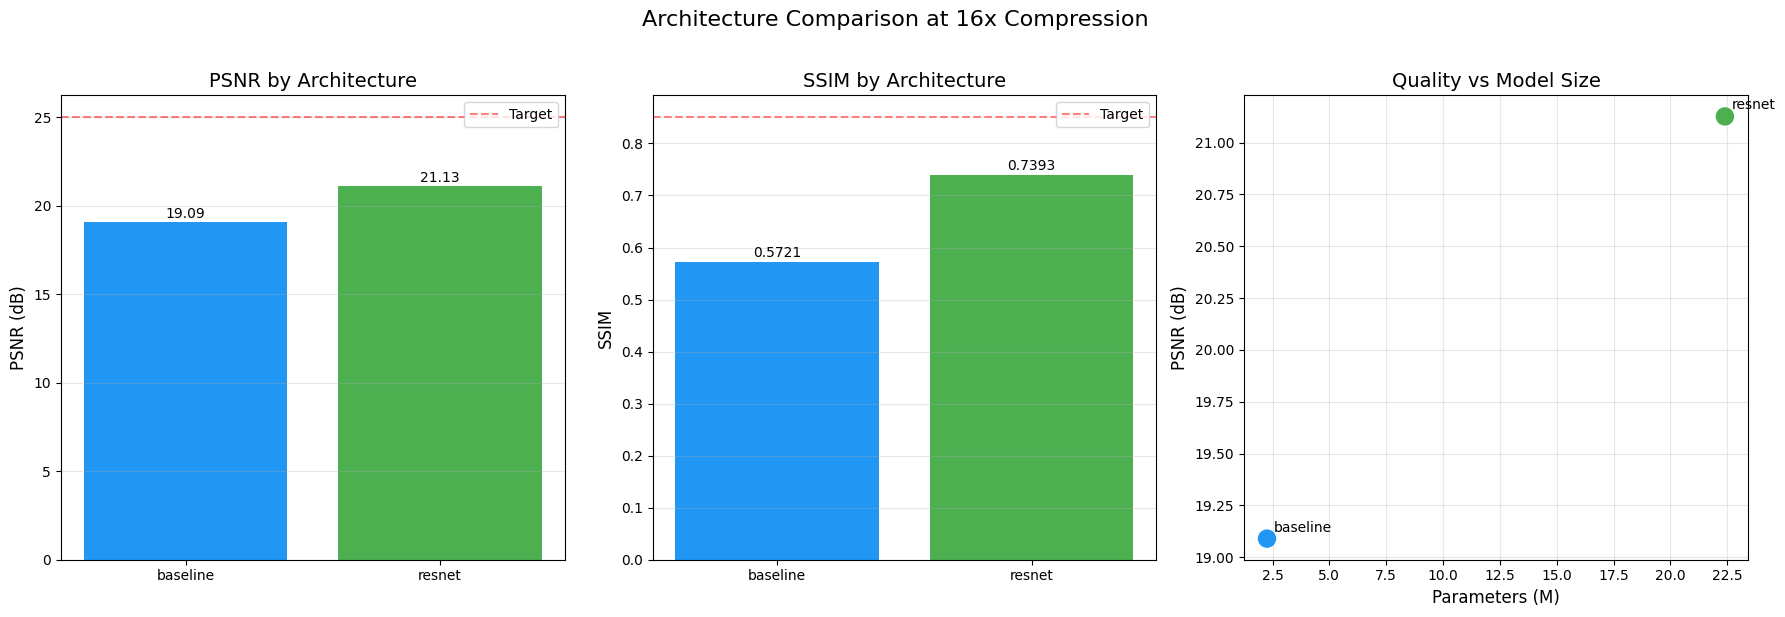

Saved to: runs/architecture_comparison_16x_20260128.png


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

models = [r['model'] for r in results if r.get('best_psnr')]
psnrs = [r['best_psnr'] for r in results if r.get('best_psnr')]
ssims = [r['best_ssim'] for r in results if r.get('best_ssim')]
param_counts = [r['parameters'] / 1e6 for r in results if r.get('best_psnr')]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ['#2196F3', '#4CAF50']

# PSNR comparison
ax = axes[0]
bars = ax.bar(models, psnrs, color=colors[:len(models)])
ax.set_ylabel('PSNR (dB)', fontsize=12)
ax.set_title('PSNR by Architecture', fontsize=14)
ax.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Target')
for bar, val in zip(bars, psnrs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.2f}', ha='center', fontsize=10)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# SSIM comparison
ax = axes[1]
bars = ax.bar(models, ssims, color=colors[:len(models)])
ax.set_ylabel('SSIM', fontsize=12)
ax.set_title('SSIM by Architecture', fontsize=14)
ax.axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target')
for bar, val in zip(bars, ssims):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', fontsize=10)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# PSNR vs Parameters (efficiency)
ax = axes[2]
ax.scatter(param_counts, psnrs, c=colors[:len(models)], s=150, zorder=5)
for m, p, psnr in zip(models, param_counts, psnrs):
    ax.annotate(m, (p, psnr), textcoords='offset points',
                xytext=(5, 5), fontsize=10)
ax.set_xlabel('Parameters (M)', fontsize=12)
ax.set_ylabel('PSNR (dB)', fontsize=12)
ax.set_title('Quality vs Model Size', fontsize=14)
ax.grid(True, alpha=0.3)

plt.suptitle('Architecture Comparison at 16x Compression', fontsize=16, y=1.02)
plt.tight_layout()

datestamp = datetime.now().strftime('%Y%m%d')
save_path = f'runs/architecture_comparison_16x_{datestamp}.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {save_path}")

Loaded previous sweep: sweep_baseline_ratios_20260127.json
  Ratios: ['4x', '8x', '12x']


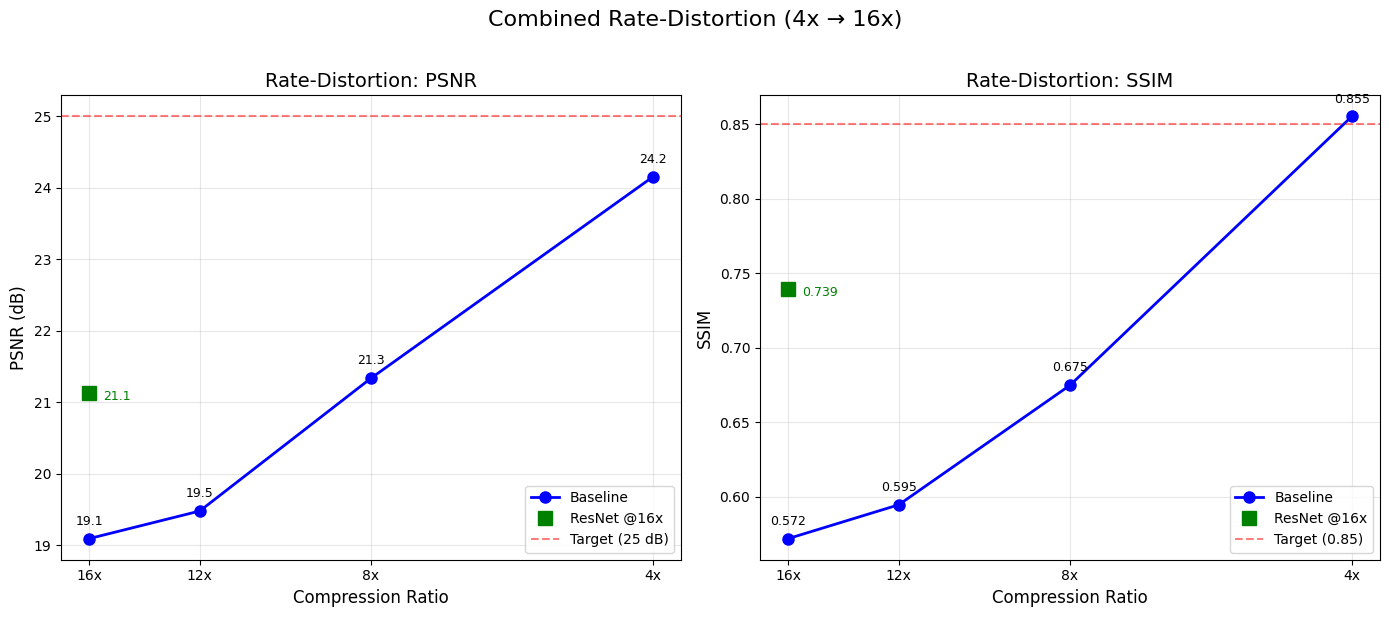


Ratio    Model              PSNR       SSIM
------------------------------------------
4x       baseline          24.15     0.8552
8x       baseline          21.34     0.6749
12x      baseline          19.48     0.5948
16x      baseline          19.09     0.5721
16x      resnet            21.13     0.7393

Saved to: runs/combined_rate_distortion_20260128.png


In [8]:
# Load baseline ratios sweep and append 16x results for combined R-D curve
import json
import matplotlib.pyplot as plt
from datetime import datetime

# Load previous baseline ratios sweep
ratios_json = sorted(Path('runs').glob('sweep_baseline_ratios*.json'), key=lambda p: p.stat().st_mtime)
if ratios_json:
    with open(ratios_json[-1]) as f:
        prev_sweep = json.load(f)
    prev_results = prev_sweep['results']
    print(f"Loaded previous sweep: {ratios_json[-1].name}")
    ratios_list = [f"{r['compression_ratio']:.0f}x" for r in prev_results]
    print(f"  Ratios: {ratios_list}")
else:
    prev_results = []
    print("No previous sweep found — plotting 16x only")

# Get best baseline result from this sweep
baseline_16x = next((r for r in results if r['model'] == 'baseline' and r.get('best_psnr')), None)
resnet_16x = next((r for r in results if r['model'] == 'resnet' and r.get('best_psnr')), None)

# Build combined baseline R-D data (4x, 8x, 12x from prev + 16x from this sweep)
bl_ratios = [r['compression_ratio'] for r in prev_results if r.get('best_psnr')]
bl_psnrs = [r['best_psnr'] for r in prev_results if r.get('best_psnr')]
bl_ssims = [r['best_ssim'] for r in prev_results if r.get('best_ssim')]

if baseline_16x:
    bl_ratios.append(16.0)
    bl_psnrs.append(baseline_16x['best_psnr'])
    bl_ssims.append(baseline_16x['best_ssim'])

# Sort by ratio
sorted_idx = sorted(range(len(bl_ratios)), key=lambda i: bl_ratios[i])
bl_ratios = [bl_ratios[i] for i in sorted_idx]
bl_psnrs = [bl_psnrs[i] for i in sorted_idx]
bl_ssims = [bl_ssims[i] for i in sorted_idx]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PSNR
ax1.plot(bl_ratios, bl_psnrs, 'bo-', markersize=8, linewidth=2, label='Baseline')
for r, p in zip(bl_ratios, bl_psnrs):
    ax1.annotate(f'{p:.1f}', (r, p), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)

if resnet_16x:
    ax1.plot(16.0, resnet_16x['best_psnr'], 'gs', markersize=10, label='ResNet @16x')
    ax1.annotate(f"{resnet_16x['best_psnr']:.1f}", (16.0, resnet_16x['best_psnr']),
                 textcoords='offset points', xytext=(10, -5), ha='left', fontsize=9, color='green')

ax1.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Target (25 dB)')
ax1.set_xlabel('Compression Ratio', fontsize=12)
ax1.set_ylabel('PSNR (dB)', fontsize=12)
ax1.set_title('Rate-Distortion: PSNR', fontsize=14)
ax1.set_xscale('log', base=2)
ax1.set_xticks(bl_ratios)
ax1.set_xticklabels([f'{int(r)}x' for r in bl_ratios])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()

# SSIM
ax2.plot(bl_ratios, bl_ssims, 'bo-', markersize=8, linewidth=2, label='Baseline')
for r, s in zip(bl_ratios, bl_ssims):
    ax2.annotate(f'{s:.3f}', (r, s), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)

if resnet_16x:
    ax2.plot(16.0, resnet_16x['best_ssim'], 'gs', markersize=10, label='ResNet @16x')
    ax2.annotate(f"{resnet_16x['best_ssim']:.3f}", (16.0, resnet_16x['best_ssim']),
                 textcoords='offset points', xytext=(10, -5), ha='left', fontsize=9, color='green')

ax2.axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
ax2.set_xlabel('Compression Ratio', fontsize=12)
ax2.set_ylabel('SSIM', fontsize=12)
ax2.set_title('Rate-Distortion: SSIM', fontsize=14)
ax2.set_xscale('log', base=2)
ax2.set_xticks(bl_ratios)
ax2.set_xticklabels([f'{int(r)}x' for r in bl_ratios])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.suptitle('Combined Rate-Distortion (4x → 16x)', fontsize=16, y=1.02)
plt.tight_layout()

datestamp = datetime.now().strftime('%Y%m%d')
save_path = f'runs/combined_rate_distortion_{datestamp}.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

# Print combined table
print(f"\n{'Ratio':<8} {'Model':<12} {'PSNR':>10} {'SSIM':>10}")
print("-" * 42)
for r, p, s in zip(bl_ratios, bl_psnrs, bl_ssims):
    ratio_str = f"{int(r)}x"
    print(f"{ratio_str:<8} {'baseline':<12} {p:>10.2f} {s:>10.4f}")
if resnet_16x:
    print(f"{'16x':<8} {'resnet':<12} {resnet_16x['best_psnr']:>10.2f} {resnet_16x['best_ssim']:>10.4f}")

print(f"\nSaved to: {save_path}")

## 7. Save Results to JSON

In [9]:
import json
from datetime import datetime

datestamp = datetime.now().strftime('%Y%m%d')

output = {
    'sweep_type': 'architecture_comparison_16x',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'latent_channels': LATENT_CHANNELS,
        'compression_ratio': compression_ratio,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'train_subset': TRAIN_SUBSET,
    },
    'results': results,
}

output_path = Path(f'runs/sweep_all_16x_{datestamp}.json')
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)

print(f"Results saved to: {output_path}")

Results saved to: runs\sweep_all_16x_20260128.json


---

## Done!

**Next steps:**
1. View TensorBoard: `tensorboard --logdir=runs`
2. Compare with baseline rate-distortion curves from `sweep_baseline_ratios.ipynb`
3. Pick best architecture and sweep its compression ratios